In [1]:
import base64
import warnings
warnings.filterwarnings("ignore")

In [14]:
from quickstart import get_service, get_data
service = get_service()
messages = get_data(service, 'MIT Download')

In [15]:
print(len(messages))

34


In [16]:
message = messages[2]
msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
content = msg['payload']['parts'][0]['body']['data']
msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
start_str = 'to get The Download every day.\r\n\r\n'
content_str = msg_body[msg_body.find(start_str) + len(start_str):msg_body.find('We can still have nice things')]
articles = content_str.split('------------------------------------------------------------')
print(len(articles), articles[0])

2 How the world already prevented far worse warming this century

https://www.technologyreview.com/2021/08/18/1032168/montreal-protocol-warming-lessons-climate-change-ozone/?truid=&utm_source=the_download&utm_medium=email&utm_campaign=the_download.unpaid.engagement&utm_term=&utm_content=08-19-2021&mc_cid=7fce136b2d&mc_eid=UNIQID

An impressive achievement: The world has already banded together to enact an international treaty that prevented significant global warming this century—even though that wasn’t the driving goal.

The specifics: In 1987, dozens of nations adopted the Montreal Protocol, agreeing to phase out the use of substances that were breaking down the ozone layer. But since many of them are also powerful greenhouse gases, as a major side benefit (https://www.technologyreview.com/2021/08/18/1032168/montreal-protocol-warming-lessons-climate-change-ozone/?truid=&utm_source=the_download&utm_medium=email&utm_campaign=the_download.unpaid.engagement&utm_term=&utm_content=08-19-20

In [25]:
import base64
import re
from tqdm import tqdm
import pandas as pd

def parse_main_reads(date, msg_body):
    """ Returns a list of article information"""
    
    start_str = 'to get The Download every day.\r\n\r\n'
    content_str = msg_body[msg_body.find(start_str) + len(start_str):msg_body.find('We can still have nice things')]
    content_str = re.sub(r"http\S+", "", content_str, flags=re.MULTILINE)
    content_str = re.sub(r" \( ", "", content_str, flags=re.MULTILINE)
    content_str = re.sub(r'\r\n', ' ', content_str, flags=re.MULTILINE)
    articles = content_str.split('------------------------------------------------------------')
    articles = [text[:text.find('Read the full story')] for text in articles]
    return articles

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def parse_must_reads(date, msg_body):
    """ Returns a list of article information
        title, subtitle, author, publication, minutes (reading time)"""
    
    must_reads = msg_body[msg_body.index('The must-reads'):]
    text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE)
    text = deEmojify(text)
    articles = []
    for i in range(1, 11):
        try:
            articles.append(list(re.findall('\n' + str(i) + ' (.*)\r\n(.*) \((.*) \r\n', text, re.MULTILINE)[0]))
        except:
            try:
                articles.append(list(re.findall('\n' + str(i) + ' (.*)\r\n(.*)\((.*) \r\n', text, re.MULTILINE)[0]))
            except:
                continue
    return articles

data = []
num_articles_fetched = []
for message in tqdm(messages):
    
    # Get an email by id
    msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
    
    # Get date of email for the purpose of topic modeling over time
    for date_dict in msg['payload']['headers']:
        if date_dict['name'] == 'Date':
            date = date_dict['value']
    date = pd.to_datetime(date)

    # Get the email body
    content = msg['payload']['parts'][0]['body']['data']
    msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
    
    # Extract article information for all articles featured in daily digest
    if msg_body.find('The must-reads') != -1:
        fetched_articles = parse_must_reads(date, msg_body)
        for must_reads in fetched_articles:
            data.append([date, *must_reads])
    else:
        continue

100%|██████████| 34/34 [00:05<00:00,  6.74it/s]


In [35]:
print(len(data))
deEmojify(data[-1][1])

299


'Bendable ice is a thing that exists 🧊'

In [49]:
import emoji
def remove_emojis(text: str) -> str:
    text = str(text.encode('unicode-escape'))
    return ''.join(c for c in text if c not in emoji.UNICODE_EMOJI)

remove_emojis(data[-1][1])

"b'Bendable ice is a thing that exists \\\\U0001f9ca'"

In [27]:
df = pd.DataFrame(data, columns = ['Date', 'Title', 'Subtitle', 'Source'])
df.to_csv('must_reads_MIT_download.csv', index=False)
df['combined'] = df[['Title', 'Subtitle']].agg(' '.join, axis=1)
df

,Date,Title,Subtitle,Source,combined
0,2021-08-23 12:02:55+00:00,How the Taliban mastered social media,The Afghanistan of today is very different fro...,NYT,How the Taliban mastered social media The Afgh...
1,2021-08-23 12:02:55+00:00,You might have already had a breakthrough covi...,"Yet again, efforts to fight the virus are bein...",New Yorker,You might have already had a breakthrough covi...
2,2021-08-23 12:02:55+00:00,Amazon's next big idea? Build department stores,And thus the cycle of tech companies inventing...,The Atlantic,Amazon's next big idea? Build department store...
3,2021-08-23 12:02:55+00:00,China has just passed one of the world's stric...,This will curb data collection by private comp...,WSJ,China has just passed one of the world's stric...
4,2021-08-23 12:02:55+00:00,We need to treat space traffic like we treat t...,Maritime law could help us to prevent a future...,TR,We need to treat space traffic like we treat t...
...,...,...,...,...,...
294,2021-07-12 12:07:58+00:00,How a ransomware attack works,"This breaks the anatomy of these hacks down, s...",WP,How a ransomware attack works This breaks the ...
295,2021-07-12 12:07:58+00:00,Amazon is pulling brands from its store—and co...,There has to be a better way of dealing with i...,The Verge,Amazon is pulling brands from its store—and co...
296,2021-07-12 12:07:58+00:00,How to make working remotely work,"Out with surveillance and visible busyness, in...",New Yorker,How to make working remotely work Out with sur...
297,2021-07-12 12:07:58+00:00,In defense of Twitter,"Yes, it can be awful. But it can be wonderful,...",FT,"In defense of Twitter Yes, it can be awful. Bu..."


<AxesSubplot:>

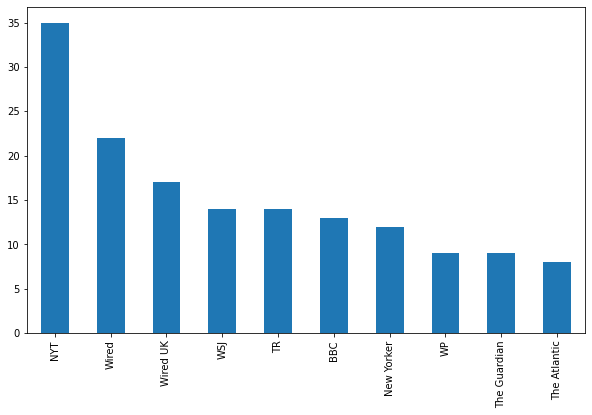

In [24]:
df['Source'].value_counts().iloc[:10].plot.bar(figsize=(10,6))

(-0.5, 2999.5, 1999.5, -0.5)

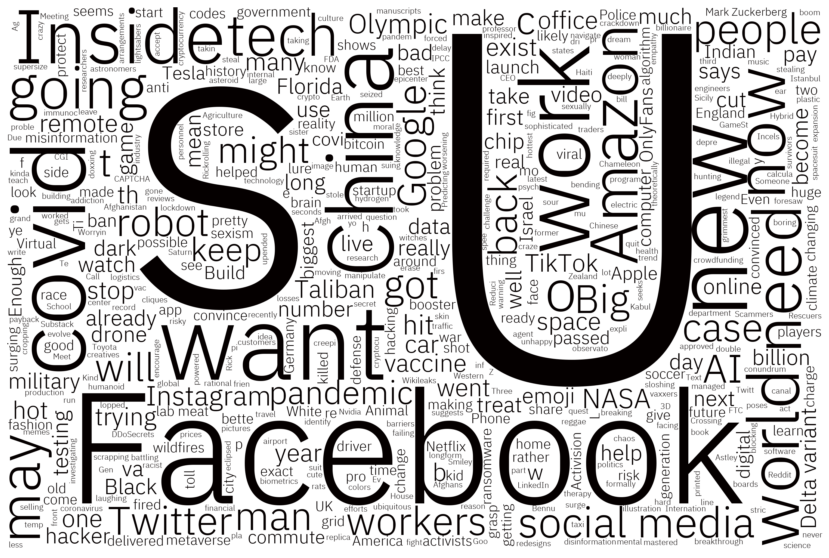

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
# set the wordcloud background color to white
# set max_words to 1000
# set width and height to higher quality, 3000 x 2000
wordcloud = WordCloud(font_path = '~/Library/Fonts/IBMPlexSans-Light.ttf', 
                      background_color="white", width=3000, height=2000, collocations=True,
                      max_words=500).generate_from_text(df['combined'].to_string())
# set the word color to black
wordcloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[15,10])
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")